PINN_Elliptic2D (cuda): [3000/30000] Total=6.356e-03 | PDE=1.084e-03 | BC=5.271e-03
PINN_Elliptic2D (cuda): [6000/30000] Total=6.736e-04 | PDE=2.277e-04 | BC=4.460e-04
PINN_Elliptic2D (cuda): [9000/30000] Total=2.115e-03 | PDE=2.066e-03 | BC=4.953e-05
PINN_Elliptic2D (cuda): [12000/30000] Total=1.911e-04 | PDE=1.719e-04 | BC=1.925e-05
PINN_Elliptic2D (cuda): [15000/30000] Total=3.896e-05 | PDE=2.846e-05 | BC=1.050e-05
PINN_Elliptic2D (cuda): [18000/30000] Total=6.110e-04 | PDE=6.019e-04 | BC=9.136e-06
PINN_Elliptic2D (cuda): [21000/30000] Total=1.705e-04 | PDE=1.648e-04 | BC=5.708e-06
PINN_Elliptic2D (cuda): [24000/30000] Total=1.719e-05 | PDE=1.383e-05 | BC=3.356e-06
PINN_Elliptic2D (cuda): [27000/30000] Total=2.853e-04 | PDE=2.820e-04 | BC=3.373e-06
PINN_Elliptic2D (cuda): [30000/30000] Total=1.085e-04 | PDE=1.057e-04 | BC=2.827e-06


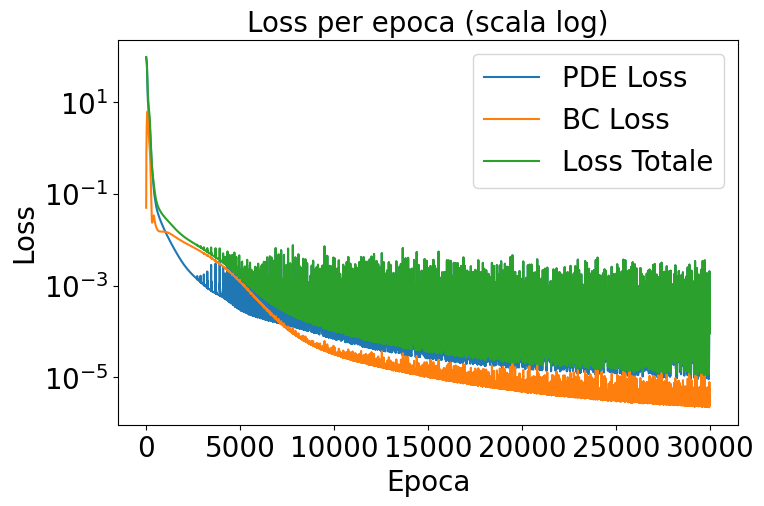

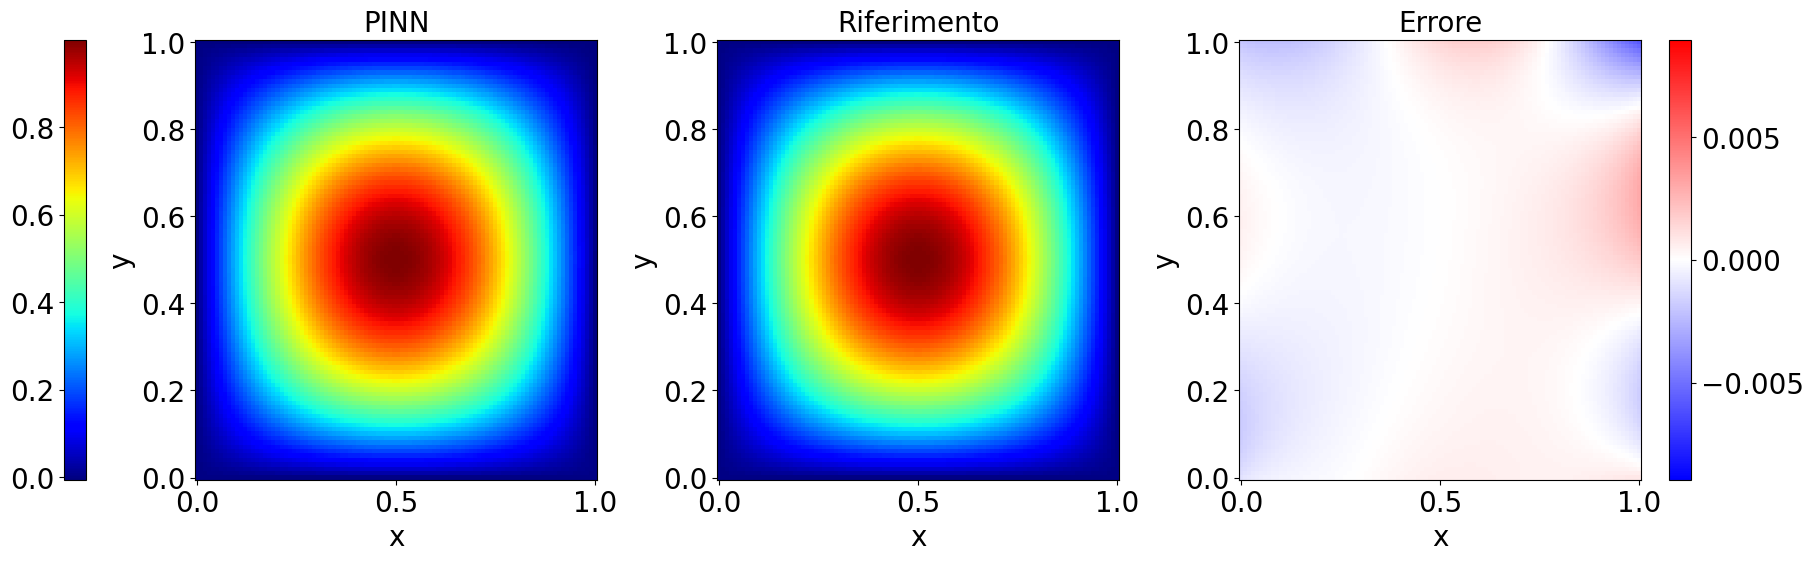


Metriche di Errore L2
---------------------
Errore L2 assoluto            : 7.550979e-02
Errore L2 relativo            : 1.525450e-03



In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

class PINN_Elliptic2D:
    def __init__(
        self, x, y, f_func, x_range, y_range, layers,
        epochs=5000, nu=1.0,
        N_col=10000, N_bc=1000,
        lr=1e-3, exact_solution=None,
        bc_type='dirichlet', path=None,
        device: str = None,
        grid_size: int = 1000
    ):
        # Device: user override or auto-detect
        if device:
            self.device = torch.device(device)
        else:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Parameters
        self.epochs = epochs
        self.nu = nu
        self.x=x
        self.t=y
        self.N_col = N_col
        self.N_bc = N_bc
        self.lr = lr
        self.f_func = f_func  # source term f(x,y)
        self.exact_solution = exact_solution
        self.bc_type = bc_type.lower()
        self.path = path
        # losses: list of tuples (phys_loss, bc_loss, total_loss)
        self.losses = []
        self.loaded = None

        # Build MLP model
        layers_seq = []
        for i in range(len(layers)-1):
            layers_seq.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                layers_seq.append(nn.Tanh())
        self.model = nn.Sequential(*layers_seq).to(self.device)

        # Load existing state
        if path:
            try:
                self.model.load_state_dict(torch.load(path, map_location=self.device))
                self.losses = np.load(path.replace('.pth', '_losses.npy')).tolist()
                self.loaded = True
            except FileNotFoundError:
                self.loaded = False

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        # Domain and fixed grid
        self.x_min, self.x_max = x_range
        self.y_min, self.y_max = y_range
        x_lin = np.linspace(self.x_min, self.x_max, grid_size)
        y_lin = np.linspace(self.y_min, self.y_max, grid_size)
        xx, yy = np.meshgrid(x_lin, y_lin)
        xy = np.vstack([xx.ravel(), yy.ravel()]).T.astype(np.float32)
        self.xy_grid = torch.tensor(xy, device=self.device)

    def sample_collocation(self):
        idx = torch.randperm(self.xy_grid.size(0), device=self.device)[:self.N_col]
        xy = self.xy_grid[idx].clone().requires_grad_(True)
        return xy

    def sample_boundary(self):
        grid = self.xy_grid.view(-1, 2)
        grid_size = int(np.sqrt(grid.size(0)))
        xx = grid[:,0].view(grid_size, grid_size)
        yy = grid[:,1].view(grid_size, grid_size)
        left = torch.stack([xx[:,0], yy[:,0]], 1)
        right = torch.stack([xx[:,-1], yy[:,-1]], 1)
        bottom = torch.stack([xx[0,:], yy[0,:]], 1)
        top = torch.stack([xx[-1,:], yy[-1,:]], 1)
        xb = torch.cat([left, right, bottom, top], dim=0).to(self.device)
        if self.bc_type=='dirichlet' and self.exact_solution:
            vals = []
            xb_np = xb.cpu().numpy()
            for x, y in xb_np:
                vals.append(self.exact_solution(float(x), float(y)))
            ub = torch.tensor(vals, dtype=torch.float32, device=self.device).view(-1,1)
        else:
            ub = torch.zeros((xb.size(0),1), device=self.device)
        return xb, ub

    def pde_residual(self, xy):
        u = self.model(xy)
        grads = autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = grads[:, [0]]; u_y = grads[:, [1]]
        u_xx = autograd.grad(u_x, xy, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:,[0]]
        u_yy = autograd.grad(u_y, xy, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:,[1]]
        pts = xy.cpu().detach().numpy()
        f_np = self.f_func(pts).reshape(-1,1)
        f_t = torch.tensor(f_np, dtype=torch.float32, device=self.device)
        return -self.nu*(u_xx + u_yy) - f_t

    def compute_loss(self):
        xy_f = self.sample_collocation()
        res = self.pde_residual(xy_f)
        loss_phys = self.loss_fn(res, torch.zeros_like(res, device=self.device))
        xb, ub = self.sample_boundary()
        u_b = self.model(xb)
        loss_bc = self.loss_fn(u_b, ub)
        total_loss = loss_phys + loss_bc
        return total_loss, (loss_phys.item(), loss_bc.item())

    def Train(self):
        self.model.train()
        for ep in range(1, self.epochs+1):
            self.optimizer.zero_grad()
            total, (lp, lb) = self.compute_loss()
            total.backward()
            self.optimizer.step()
            # record losses
            self.losses.append((lp, lb, total.item()))
            if ep % (self.epochs//10 or 1) == 0:
                print(f"PINN_Elliptic2D ({self.device}): [{ep}/{self.epochs}] Total={total.item():.3e} | PDE={lp:.3e} | BC={lb:.3e}")
        if self.path and not self.loaded:
            torch.save(self.model.state_dict(), self.path)
            np.save(self.path.replace('.pth', '_losses.npy'), np.array(self.losses))

    def plot_losses(self):
        import matplotlib.pyplot as plt
        if not self.losses:
            print("No losses to plot.")
            return
        # unpack losses
        phys = [l[0] for l in self.losses]
        bc   = [l[1] for l in self.losses]
        tot  = [l[2] for l in self.losses]
        epochs = list(range(1, len(self.losses)+1))
        plt.figure(figsize=(8,5))
        plt.plot(epochs, phys, label='PDE Loss')
        plt.plot(epochs, bc,   label='BC Loss')
        plt.plot(epochs, tot,  label='Loss Totale')
        plt.xlabel('Epoca')
        plt.ylabel('Loss')
        plt.legend()
        plt.yscale('log')
        plt.title('Loss per epoca (scala log)')
        plt.show()

    def predict(self, x_star, y_star):
        self.model.eval()
        with torch.no_grad():
            pts = np.vstack([x_star.ravel(), y_star.ravel()]).T.astype(np.float32)
            xy = torch.tensor(pts, device=self.device)
            u = self.model(xy).cpu().numpy().reshape(x_star.shape)
        return u

    def plot_comparison(self, x_star=None, y_star=None):
        # Prepare evaluation grid if not provided
        if x_star is None or y_star is None:
            grid_pts = self.xy_grid.cpu().numpy()
            n = int(np.sqrt(grid_pts.shape[0]))
            x_lin = np.unique(grid_pts[:,0])
            y_lin = np.unique(grid_pts[:,1])
            x_star, y_star = np.meshgrid(x_lin, y_lin)
        # Compute fields
        self.U_pred = self.predict(x_star, y_star)
        self.U_exact = np.zeros_like(self.U_pred)
        if self.exact_solution:
            for i in range(x_star.shape[0]):
                for j in range(x_star.shape[1]):
                    self.U_exact[i,j] = self.exact_solution(x_star[i,j], y_star[i,j])
        self.U_err = self.U_pred - self.U_exact
        # Shared color scale for PINN and Exact
        vmin = min(self.U_pred.min(), self.U_exact.min())
        vmax = max(self.U_pred.max(), self.U_exact.max())
        # Symmetric scale for error
        vmean = max(abs(vmin), abs(vmax))


        # dimensione font
        plt.rcParams.update({
            'font.size':       20,
            'axes.titlesize':  20,
            'axes.labelsize':  20,
            'xtick.labelsize': 20,
            'ytick.labelsize': 20,
            'legend.fontsize': 20,
        })

        # limiti dati
        vmin = vmin if vmin is not None else min(self.U_pred.min(), self.U_exact.min())
        vmax = vmax if vmax is not None else max(self.U_pred.max(), self.U_exact.max())
        verr = abs(self.U_err[:-2].max())

        # figura 2×3 con constrained_layout
        fig, axs = plt.subplots(1, 3, figsize=(18, 5.5), constrained_layout=True)

        # --- RIGA 1: le tre mappe -----------------------------------------------
        # 1) PINN
        im_pred = axs[0].pcolormesh(self.x, self.t, self.U_pred,
                                    shading='auto', cmap='jet',
                                    vmin=vmin, vmax=vmax)
        
        title0 = "PINN"
        axs[0].set_title(title0)
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("y")

        # 2) Riferimento
        im_ref = axs[1].pcolormesh(self.x, self.t, self.U_exact,
                                    shading='auto', cmap='jet',
                                    vmin=vmin, vmax=vmax)
        
        axs[1].set_title("Riferimento")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("y")

        # 3) Errore
        im_err = axs[2].pcolormesh(self.x, self.t, self.U_err,
                                    shading='auto', cmap='bwr',
                                    vmin=-verr*3, vmax=verr*3)
        axs[2].set_title("Errore")
        axs[2].set_xlabel("x")
        axs[2].set_ylabel("y")

        # unica colorbar a sinistra per PINN+Riferimento
        cbar_left = fig.colorbar(
            im_pred,
            ax=[axs[0], axs[1]],
            location='left',
            pad=0.02,
        )
        cbar_left.ax.yaxis.set_tick_params(labelsize=20)
        cbar_left.ax.yaxis.label.set_size(20)

        # unica colorbar a destra per Errore
        cbar_right = fig.colorbar(
            im_err,
            ax=axs[2],
            location='right',
            pad=0.02,
        )
        cbar_right.ax.yaxis.set_tick_params(labelsize=20)
        cbar_right.ax.yaxis.label.set_size(20)
        plt.show()


    def compute_L2_error(self, x_star=None, y_star=None):
        """
        Calcola e stampa l'errore L2 assoluto e relativo della soluzione PINN
        rispetto alla soluzione esatta su una griglia o sui punti forniti.
        """
        import numpy as _np

        # --- Preparazione dei punti di valutazione ---
        if x_star is None or y_star is None:
            pts = self.xy_grid.cpu().numpy()
            x_star = pts[:, 0].reshape(-1, 1)
            y_star = pts[:, 1].reshape(-1, 1)

        # --- Predizione e soluzioni esatte ---
        u_pred = self.predict(x_star, y_star).ravel()
        if self.exact_solution is None:
            raise ValueError("Exact solution not provided.")
        u_ex = _np.array([
            self.exact_solution(float(x), float(y))
            for x, y in zip(x_star.ravel(), y_star.ravel())
        ])

        # --- Calcolo errori L2 ---
        # Errore assoluto quadratico integrale
        l2_abs = _np.linalg.norm(u_pred - u_ex)
        # Normale L2 della soluzione esatta
        l2_exact = _np.linalg.norm(u_ex)
        # Errore relativo
        l2_rel = l2_abs / l2_exact if l2_exact != 0 else float('inf')

        # --- Stampa dei risultati ---
        header = "Metriche di Errore L2"
        print(f"\n{header}\n{'-' * len(header)}")
        print(f"{'Errore L2 assoluto':<30}: {l2_abs:.6e}")
        print(f"{'Errore L2 relativo':<30}: {l2_rel:.6e}\n")

        return l2_abs, l2_rel



# --- Example usage for Poisson 2D on [0,1]^2 ---
if __name__ == "__main__":
    import numpy as np
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    f_func = lambda pts: 2*(np.pi**2)*np.sin(np.pi*pts[:,0])*np.sin(np.pi*pts[:,1])
    exact = lambda x,y: np.sin(np.pi*x)*np.sin(np.pi*y)
    pinn = PINN_Elliptic2D(
        x, y, f_func, (0,1), (0,1), layers=[2,50,50,1],
        epochs=30000, N_col=10000, N_bc=2000,
        lr=1e-3, exact_solution=exact,
        device='cuda', grid_size=100
    )
    pinn.Train()
    pinn.plot_losses()
    pinn.plot_comparison()
    pinn.compute_L2_error()


In [ ]:
pinn.compute_L2_error()


Metriche di Errore L2
---------------------
Errore L2 assoluto            : 7.133945e-02
Errore L2 relativo            : 1.441201e-03



(np.float64(0.07133945161003442), np.float64(0.0014412010404678563))